# Experiment: MSFT 1-Minute GRU Forecast (Anti-Linear v3)

This notebook implements the six requested anti-linear fixes plus volume/order-flow integration:
1. Market-calendar sessionization (no hard 390 assumption) + high-fill session drop
2. Imputation policy update: drop windows only if target horizon touches imputed bars; add `imputedFracWindow` feature
3. Lookback sweep (`96/160/256`) before final fold runs
4. Probabilistic decoder (`mu` + `sigma`) with Gaussian NLL
5. Relaxed clipping + variance-matching loss
6. Aggressive teacher-forcing decay to near-zero by epoch 10


In [1]:
# Optional dependency bootstrap
import importlib.util
import subprocess
import sys

required = {
    'alpaca': 'alpaca-py',
    'numpy': 'numpy',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'pandas_market_calendars': 'pandas-market-calendars',
}

missing = [pkg for mod, pkg in required.items() if importlib.util.find_spec(mod) is None]
if missing:
    print('Installing missing packages:', missing)
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *missing])
else:
    print('All required third-party packages are already installed.')


All required third-party packages are already installed.


In [2]:
# Setup
from __future__ import annotations

import copy
import os
import random
import time
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import torch
import torch.nn as nn
from alpaca.data.enums import DataFeed
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Rectangle
from torch.utils.data import DataLoader, Dataset

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.benchmark = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {DEVICE}')
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))
    print('CUDA:', torch.version.cuda)


Using device: cuda
GPU: NVIDIA GeForce RTX 3070
CUDA: 12.1


## Configuration

Defaults are tuned for free-plan IEX while reducing linear-collapse behavior.


In [3]:
# Configuration
SYMBOL = 'MSFT'
LOOKBACK_DAYS = 60

OHLC_COLS = ['Open', 'High', 'Low', 'Close']
RAW_COLS = OHLC_COLS + ['Volume', 'TradeCount', 'VWAP']

BASE_FEATURE_COLS = [
    'rOpen',
    'rHigh',
    'rLow',
    'rClose',
    'logVolChange',
    'logTradeCountChange',
    'vwapDelta',
    'rangeFrac',
    'orderFlowProxy',
    'tickPressure',
]
TARGET_COLS = ['tClose', 'tLogRange', 'tOpenFrac', 'tCloseFrac']
INPUT_EXTRA_COL = 'imputedFracWindow'

HORIZON = 30
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15

LOOKBACK_CANDIDATES = [64, 96, 160, 256]
DEFAULT_LOOKBACK = 96
ENABLE_LOOKBACK_SWEEP = True
SKIP_OPEN_BARS_TARGET = 6

# Model capacity / regularization
HIDDEN_SIZE = 256
NUM_LAYERS = 3
DROPOUT = 0.12
LEARNING_RATE = 8e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 192

# Training schedules
SWEEP_MAX_EPOCHS = 12
SWEEP_PATIENCE = 4
FINAL_MAX_EPOCHS = 40
FINAL_PATIENCE = 9
TF_START = 1.0
TF_END = 0.0
TF_RAMP_EPOCHS = 16

# Target geometry and realism
TARGET_EPS = 1e-6
TARGET_MAX_RANGE = 0.03
STEP_LOSS_POWER = 1.35
RANGE_REALISM_WEIGHT = 0.10
FLIP_REALISM_WEIGHT = 0.08

# Probabilistic + auxiliary objectives
MU_HUBER_WEIGHT = 0.50
HUBER_DELTA = 1.0
NLL_WEIGHTS = np.array([2.2, 1.0, 0.8, 0.8], dtype=np.float32)
HUBER_WEIGHTS = np.array([2.4, 1.0, 0.8, 0.8], dtype=np.float32)
DIR_LOSS_WEIGHT = 0.05
VAR_MATCH_WEIGHT = 0.12
LOG_SIGMA_MAX = -0.50

# Clipping / sampling
APPLY_CLIPPING = True
CLIP_QUANTILES = (0.01, 0.99)
INFER_SAMPLE_TEMPERATURE = 0.10
MAX_SIGMA_SCALE = 0.16
SAMPLE_NOISE_TRUNC = 1.20
BLEND_SAMPLE_WITH_MEAN = 0.22
MC_SAMPLE_COUNT = 7

# Adaptive recursive guards
RECURSIVE_VOL_WINDOW = 64
RECURSIVE_CLOSE_SIGMA_MULT = 2.0
RECURSIVE_RANGE_MULT = 2.0
RECURSIVE_MIN_RANGE_ABS = 3.5e-4
RECURSIVE_MAX_RANGE_ABS = TARGET_MAX_RANGE
NONPRICE_DECAY = 0.72

# Diagnostics
DIRECTION_EPS = 0.02
STD_RATIO_TARGET_MIN = 0.45

# Session and feed
ALPACA_FEED = os.getenv('ALPACA_FEED', 'iex').strip().lower()
SESSION_TZ = 'America/New_York'
REQUEST_CHUNK_DAYS = 5
MAX_REQUESTS_PER_MINUTE = 120
MAX_RETRIES = 5
MAX_SESSION_FILL_RATIO = 0.08

print({
    'symbol': SYMBOL,
    'lookback_days': LOOKBACK_DAYS,
    'lookback_candidates': LOOKBACK_CANDIDATES,
    'horizon': HORIZON,
    'feed': ALPACA_FEED,
    'skip_open_bars_target': SKIP_OPEN_BARS_TARGET,
    'max_session_fill_ratio': MAX_SESSION_FILL_RATIO,
    'clip_quantiles': CLIP_QUANTILES,
    'tf_ramp_epochs': TF_RAMP_EPOCHS,
    'device': str(DEVICE),
})


{'symbol': 'MSFT', 'lookback_days': 60, 'lookback_candidates': [64, 96, 160, 256], 'horizon': 30, 'feed': 'iex', 'skip_open_bars_target': 6, 'max_session_fill_ratio': 0.08, 'clip_quantiles': (0.01, 0.99), 'tf_ramp_epochs': 16, 'device': 'cuda'}


In [4]:
# Data pull + calendar-aware sessionization
class RequestPacer:
    def __init__(self, max_calls_per_minute: int):
        if max_calls_per_minute <= 0:
            raise ValueError('max_calls_per_minute must be > 0')
        self.min_interval = 60.0 / float(max_calls_per_minute)
        self.last_call_ts = 0.0

    def wait(self) -> None:
        now = time.monotonic()
        elapsed = now - self.last_call_ts
        if elapsed < self.min_interval:
            time.sleep(self.min_interval - elapsed)
        self.last_call_ts = time.monotonic()


def _require_alpaca_credentials() -> tuple[str, str]:
    api_key = os.getenv('ALPACA_API_KEY')
    secret_key = os.getenv('ALPACA_SECRET_KEY')
    if not api_key or not secret_key:
        raise RuntimeError('Missing ALPACA_API_KEY / ALPACA_SECRET_KEY.')
    return api_key, secret_key


def _resolve_feed(feed_name: str) -> DataFeed:
    mapping = {'iex': DataFeed.IEX, 'sip': DataFeed.SIP, 'delayed_sip': DataFeed.DELAYED_SIP}
    k = feed_name.strip().lower()
    if k not in mapping:
        raise ValueError(f'Unsupported ALPACA_FEED={feed_name!r}. Use one of: {list(mapping)}')
    return mapping[k]


def fetch_bars_alpaca(symbol: str, lookback_days: int) -> tuple[pd.DataFrame, int]:
    api_key, secret_key = _require_alpaca_credentials()
    client = StockHistoricalDataClient(api_key=api_key, secret_key=secret_key)

    feed = _resolve_feed(ALPACA_FEED)
    pacer = RequestPacer(MAX_REQUESTS_PER_MINUTE)

    end_ts = datetime.now(timezone.utc).replace(second=0, microsecond=0)
    if ALPACA_FEED in {'sip', 'delayed_sip'}:
        end_ts = end_ts - timedelta(minutes=20)
    start_ts = end_ts - timedelta(days=lookback_days)

    parts = []
    cursor = start_ts
    calls = 0

    while cursor < end_ts:
        chunk_end = min(cursor + timedelta(days=REQUEST_CHUNK_DAYS), end_ts)
        chunk = None

        for attempt in range(1, MAX_RETRIES + 1):
            pacer.wait()
            calls += 1
            try:
                req = StockBarsRequest(
                    symbol_or_symbols=[symbol],
                    timeframe=TimeFrame.Minute,
                    start=cursor,
                    end=chunk_end,
                    feed=feed,
                    limit=10000,
                )
                chunk = client.get_stock_bars(req).df
                break
            except Exception as exc:
                msg = str(exc).lower()
                if ('429' in msg or 'rate limit' in msg) and attempt < MAX_RETRIES:
                    backoff = min(2 ** attempt, 30)
                    print(f'Rate-limited; sleeping {backoff}s (attempt {attempt}/{MAX_RETRIES}).')
                    time.sleep(backoff)
                    continue
                if ('subscription' in msg or 'forbidden' in msg) and ALPACA_FEED != 'iex':
                    raise RuntimeError('Feed unavailable for account. Use ALPACA_FEED=iex or upgrade subscription.') from exc
                raise

        if chunk is not None and not chunk.empty:
            d = chunk.reset_index().rename(
                columns={
                    'timestamp': 'Datetime',
                    'open': 'Open',
                    'high': 'High',
                    'low': 'Low',
                    'close': 'Close',
                    'volume': 'Volume',
                    'trade_count': 'TradeCount',
                    'vwap': 'VWAP',
                }
            )
            if 'Volume' not in d.columns:
                d['Volume'] = 0.0
            if 'TradeCount' not in d.columns:
                d['TradeCount'] = 0.0
            if 'VWAP' not in d.columns:
                d['VWAP'] = d['Close']

            need = ['Datetime'] + RAW_COLS
            missing = [c for c in need if c not in d.columns]
            if missing:
                raise RuntimeError(f'Alpaca response missing columns: {missing}')

            d['Datetime'] = pd.to_datetime(d['Datetime'], utc=True)
            d = d[need].dropna(subset=OHLC_COLS).set_index('Datetime').sort_index()
            parts.append(d)

        cursor = chunk_end

    if not parts:
        raise RuntimeError('No bars returned from Alpaca.')

    out = pd.concat(parts, axis=0).sort_index()
    out = out[~out.index.duplicated(keep='last')]
    return out.astype(np.float32), calls


def sessionize_with_calendar(df_utc: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
    if df_utc.empty:
        raise RuntimeError('Input bars are empty.')

    idx = pd.DatetimeIndex(df_utc.index)
    if idx.tz is None:
        idx = idx.tz_localize('UTC')
    else:
        idx = idx.tz_convert('UTC')
    df_utc = df_utc.copy()
    df_utc.index = idx

    cal = mcal.get_calendar('XNYS')
    sched = cal.schedule(
        start_date=(idx.min() - pd.Timedelta(days=2)).date(),
        end_date=(idx.max() + pd.Timedelta(days=2)).date(),
    )

    pieces = []
    kept = 0
    dropped_high_fill = 0
    dropped_empty = 0
    fill_ratios = []
    expected_lengths = []

    for sid, (_, row) in enumerate(sched.iterrows()):
        open_ts = pd.Timestamp(row['market_open'])
        close_ts = pd.Timestamp(row['market_close'])
        if open_ts.tzinfo is None:
            open_ts = open_ts.tz_localize('UTC')
        else:
            open_ts = open_ts.tz_convert('UTC')
        if close_ts.tzinfo is None:
            close_ts = close_ts.tz_localize('UTC')
        else:
            close_ts = close_ts.tz_convert('UTC')

        exp_idx = pd.date_range(open_ts, close_ts, freq='1min', inclusive='left')
        if len(exp_idx) == 0:
            continue

        day = df_utc[(df_utc.index >= open_ts) & (df_utc.index < close_ts)][RAW_COLS].copy()
        day = day.reindex(exp_idx)

        imputed = day[OHLC_COLS].isna().any(axis=1).to_numpy()
        fill_ratio = float(imputed.mean())

        if fill_ratio >= 1.0:
            dropped_empty += 1
            continue

        if fill_ratio > MAX_SESSION_FILL_RATIO:
            dropped_high_fill += 1
            continue

        day[OHLC_COLS + ['VWAP']] = day[OHLC_COLS + ['VWAP']].ffill().bfill()
        if day['VWAP'].isna().all():
            day['VWAP'] = day['Close']
        else:
            day['VWAP'] = day['VWAP'].fillna(day['Close'])

        day['Volume'] = day['Volume'].fillna(0.0)
        day['TradeCount'] = day['TradeCount'].fillna(0.0)
        day['is_imputed'] = imputed.astype(np.int8)
        day['session_id'] = int(sid)
        day['bar_in_session'] = np.arange(len(day), dtype=np.int32)
        day['session_len'] = int(len(day))

        if day[RAW_COLS].isna().any().any():
            raise RuntimeError('NaNs remain after per-session fill.')

        pieces.append(day)
        kept += 1
        fill_ratios.append(fill_ratio)
        expected_lengths.append(len(exp_idx))

    if not pieces:
        raise RuntimeError('No sessions kept after calendar filtering and fill-ratio threshold.')

    out = pd.concat(pieces, axis=0).sort_index()

    out.index = out.index.tz_convert(SESSION_TZ).tz_localize(None)

    out = out.copy()
    for c in RAW_COLS:
        out[c] = out[c].astype(np.float32)
    out['is_imputed'] = out['is_imputed'].astype(np.int8)
    out['session_id'] = out['session_id'].astype(np.int32)
    out['bar_in_session'] = out['bar_in_session'].astype(np.int32)
    out['session_len'] = out['session_len'].astype(np.int32)

    meta = {
        'calendar_sessions_total': int(len(sched)),
        'kept_sessions': int(kept),
        'dropped_empty_sessions': int(dropped_empty),
        'dropped_high_fill_sessions': int(dropped_high_fill),
        'avg_fill_ratio_kept': float(np.mean(fill_ratios)) if fill_ratios else float('nan'),
        'max_fill_ratio_kept': float(np.max(fill_ratios)) if fill_ratios else float('nan'),
        'avg_session_minutes_kept': float(np.mean(expected_lengths)) if expected_lengths else float('nan'),
    }
    return out, meta


raw_df_utc, api_calls = fetch_bars_alpaca(SYMBOL, LOOKBACK_DAYS)
price_df, session_meta = sessionize_with_calendar(raw_df_utc)

print(f'Raw rows from Alpaca: {len(raw_df_utc):,}')
print(f'Sessionized rows kept: {len(price_df):,}')
print(f'Alpaca API calls: {api_calls} (<= {MAX_REQUESTS_PER_MINUTE}/min target)')
print('Session meta:', session_meta)

min_needed = max(LOOKBACK_CANDIDATES) + HORIZON + 1000
if len(price_df) < min_needed:
    raise RuntimeError(f'Not enough rows after session filtering ({len(price_df)}). Need at least {min_needed}.')

display(price_df.head(3))
display(price_df.tail(3))


Raw rows from Alpaca: 15,337
Sessionized rows kept: 14,640
Alpaca API calls: 12 (<= 120/min target)
Session meta: {'calendar_sessions_total': 42, 'kept_sessions': 38, 'dropped_empty_sessions': 2, 'dropped_high_fill_sessions': 2, 'avg_fill_ratio_kept': 0.006998264893001735, 'max_fill_ratio_kept': 0.0761904761904762, 'avg_session_minutes_kept': 385.2631578947368}


,Open,High,Low,Close,Volume,TradeCount,VWAP,is_imputed,session_id,bar_in_session,session_len
2025-12-15 09:30:00,480.160004,480.160004,479.570007,479.880005,3535.0,82.0,479.903748,0,0,0,390
2025-12-15 09:31:00,479.380005,479.390015,478.709991,479.200012,7530.0,127.0,479.124237,0,0,1,390
2025-12-15 09:32:00,479.279999,479.619995,479.105011,479.154999,2300.0,41.0,479.293152,0,0,2,390


,Open,High,Low,Close,Volume,TradeCount,VWAP,is_imputed,session_id,bar_in_session,session_len
2026-02-10 15:57:00,412.730011,412.940002,412.730011,412.940002,4763.0,145.0,412.868469,0,38,387,390
2026-02-10 15:58:00,412.989990,413.170013,412.980011,413.149994,3663.0,124.0,413.099915,0,38,388,390
2026-02-10 15:59:00,413.220001,413.420013,413.125000,413.320007,10255.0,279.0,413.294861,0,38,389,390


In [5]:
# Feature engineering (volume/order-flow included) + structured candle targets
def enforce_candle_validity(ohlc: np.ndarray) -> np.ndarray:
    out = np.asarray(ohlc, dtype=np.float32).copy()
    o = out[:, 0]
    h = out[:, 1]
    l = out[:, 2]
    c = out[:, 3]
    out[:, 1] = np.maximum.reduce([h, o, c])
    out[:, 2] = np.minimum.reduce([l, o, c])
    return out


def returns_to_prices_seq(return_ohlc: np.ndarray, last_close: float) -> np.ndarray:
    seq = []
    prev_close = float(last_close)
    for rO, rH, rL, rC in np.asarray(return_ohlc, dtype=np.float32):
        o = prev_close * np.exp(float(rO))
        h = prev_close * np.exp(float(rH))
        l = prev_close * np.exp(float(rL))
        c = prev_close * np.exp(float(rC))
        cand = enforce_candle_validity(np.array([[o, h, l, c]], dtype=np.float32))[0]
        seq.append(cand)
        prev_close = float(cand[3])
    return np.asarray(seq, dtype=np.float32)


def one_step_returns_to_prices_batch(return_ohlc: np.ndarray, prev_close: np.ndarray) -> np.ndarray:
    r = np.asarray(return_ohlc, dtype=np.float32)
    p = np.asarray(prev_close, dtype=np.float32)
    out = np.stack([
        p * np.exp(r[:, 0]),
        p * np.exp(r[:, 1]),
        p * np.exp(r[:, 2]),
        p * np.exp(r[:, 3]),
    ], axis=1).astype(np.float32)
    return enforce_candle_validity(out)


def returns_to_structured_targets(return_ohlc: np.ndarray) -> np.ndarray:
    arr = np.asarray(return_ohlc, dtype=np.float32)
    o = arr[:, 0]
    h = arr[:, 1]
    l = arr[:, 2]
    c = arr[:, 3]

    h = np.maximum.reduce([h, o, c])
    l = np.minimum.reduce([l, o, c])

    rng = np.maximum(h - l, TARGET_EPS)
    open_frac = np.clip((o - l) / rng, 0.0, 1.0)
    close_frac = np.clip((c - l) / rng, 0.0, 1.0)

    out = np.column_stack([c, np.log(rng), open_frac, close_frac]).astype(np.float32)
    return out


def structured_to_return_ohlc(structured: np.ndarray) -> np.ndarray:
    arr = np.asarray(structured, dtype=np.float32)
    c = arr[:, 0]
    log_rng = np.clip(arr[:, 1], np.log(TARGET_EPS), np.log(TARGET_MAX_RANGE))
    open_frac = np.clip(arr[:, 2], 0.0, 1.0)
    close_frac = np.clip(arr[:, 3], 0.0, 1.0)

    rng = np.exp(log_rng)
    l = c - close_frac * rng
    h = l + rng
    o = l + open_frac * rng

    out = np.column_stack([o, h, l, c]).astype(np.float32)
    out[:, 1] = np.maximum.reduce([out[:, 1], out[:, 0], out[:, 3]])
    out[:, 2] = np.minimum.reduce([out[:, 2], out[:, 0], out[:, 3]])
    return out


def build_feature_frame(df: pd.DataFrame) -> pd.DataFrame:
    eps = 1e-9

    g = df.groupby('session_id', sort=False)

    prev_close = g['Close'].shift(1)
    prev_close = prev_close.fillna(df['Open'])
    prev_vol = g['Volume'].shift(1).fillna(df['Volume'])
    prev_tc = g['TradeCount'].shift(1).fillna(df['TradeCount'])

    prev_imp = g['is_imputed'].shift(1).fillna(0).astype(bool)
    row_imputed = (df['is_imputed'].astype(bool) | prev_imp)
    row_open_skip = (df['bar_in_session'].astype(int) < SKIP_OPEN_BARS_TARGET)

    out = pd.DataFrame(index=df.index, dtype=np.float32)

    out['rOpen'] = np.log(df['Open'] / (prev_close + eps))
    out['rHigh'] = np.log(df['High'] / (prev_close + eps))
    out['rLow'] = np.log(df['Low'] / (prev_close + eps))
    out['rClose'] = np.log(df['Close'] / (prev_close + eps))

    out['logVolChange'] = np.log((df['Volume'] + 1.0) / (prev_vol + 1.0))
    out['logTradeCountChange'] = np.log((df['TradeCount'] + 1.0) / (prev_tc + 1.0))
    out['vwapDelta'] = np.log((df['VWAP'] + eps) / (df['Close'] + eps))
    out['rangeFrac'] = np.maximum(out['rHigh'] - out['rLow'], 0.0)

    signed_body = (df['Close'] - df['Open']) / ((df['High'] - df['Low']) + eps)
    out['orderFlowProxy'] = signed_body * np.log1p(df['Volume'])
    out['tickPressure'] = np.sign(df['Close'] - df['Open']) * np.log1p(df['TradeCount'])

    out['row_imputed'] = row_imputed.astype(np.int8).to_numpy()
    out['row_open_skip'] = row_open_skip.astype(np.int8).to_numpy()
    out['prev_close'] = prev_close.astype(np.float32).to_numpy()

    return out.astype(np.float32)


def build_target_frame(feat_df: pd.DataFrame) -> pd.DataFrame:
    ret = feat_df[['rOpen', 'rHigh', 'rLow', 'rClose']].to_numpy(np.float32)
    t = returns_to_structured_targets(ret)
    out = pd.DataFrame(t, index=feat_df.index, columns=TARGET_COLS)
    return out.astype(np.float32)


feat_df = build_feature_frame(price_df)
target_df = build_target_frame(feat_df)
print('Feature rows:', len(feat_df))
print('Rows marked imputed-sensitive:', int(feat_df['row_imputed'].sum()))
print('Rows skipped as opening-target bars:', int(feat_df['row_open_skip'].sum()))

# Structured round-trip check
first_sid = int(price_df['session_id'].iloc[0])
sub = price_df[price_df['session_id'] == first_sid].copy()
sub_feat = build_feature_frame(sub)
ret = sub_feat[['rOpen', 'rHigh', 'rLow', 'rClose']].to_numpy(np.float32)
struct = returns_to_structured_targets(ret)
ret_back = structured_to_return_ohlc(struct)

rt_max = float(np.max(np.abs(ret_back - ret)))
rt_mean = float(np.mean(np.abs(ret_back - ret)))
print({'structured_roundtrip_max_abs_error': rt_max, 'structured_roundtrip_mean_abs_error': rt_mean})
assert rt_max < 8e-4, 'Structured transform round-trip error too large.'

display(feat_df[BASE_FEATURE_COLS + ['row_imputed', 'row_open_skip', 'prev_close']].head(3))
display(target_df.head(3))


Feature rows: 14640
Rows marked imputed-sensitive: 170
Rows skipped as opening-target bars: 228
{'structured_roundtrip_max_abs_error': 1.00000761449337e-06, 'structured_roundtrip_mean_abs_error': 2.5924096203056024e-09}


,rOpen,rHigh,rLow,rClose,logVolChange,logTradeCountChange,vwapDelta,rangeFrac,orderFlowProxy,tickPressure,row_imputed,row_open_skip,prev_close
2025-12-15 09:30:00,0.000000,0.000000,-0.001230,-0.000583,0.000000,0.000000,0.000049,0.001230,-3.877652,-4.41884,0.0,1.0,480.160004
2025-12-15 09:31:00,-0.001042,-0.001022,-0.002441,-0.001418,0.756032,0.433190,-0.000158,0.001419,-2.362795,-4.85203,0.0,1.0,479.880005
2025-12-15 09:32:00,0.000167,0.000876,-0.000198,-0.000094,-1.185684,-1.114361,0.000288,0.001074,-1.878965,-3.73767,0.0,1.0,479.200012


,tClose,tLogRange,tOpenFrac,tCloseFrac
2025-12-15 09:30:00,-0.000583,-6.701143,1.000000,0.525596
2025-12-15 09:31:00,-0.001418,-6.557454,0.985288,0.720762
2025-12-15 09:32:00,-0.000094,-6.836079,0.339888,0.097108


In [6]:
# Windowing/splits + lookback sweep helpers
def fit_standardizer(train_values: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    mean = train_values.mean(axis=0)
    std = train_values.std(axis=0)
    std = np.where(std < 1e-8, 1.0, std)
    return mean.astype(np.float32), std.astype(np.float32)


def apply_standardizer(values: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return ((values - mean) / std).astype(np.float32)


def undo_standardizer(values: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return (values * std + mean).astype(np.float32)


def split_points(n_rows: int) -> tuple[int, int]:
    tr = int(n_rows * TRAIN_RATIO)
    va = int(n_rows * (TRAIN_RATIO + VAL_RATIO))
    return tr, va


def build_walkforward_slices(price_df_full: pd.DataFrame) -> list[tuple[str, int, int]]:
    n = len(price_df_full)
    span = int(round(n * 0.85))
    shift = max(1, n - span)

    cands = [('slice_1', 0, min(span, n)), ('slice_2', shift, min(shift + span, n))]

    out = []
    seen = set()
    for name, a, b in cands:
        key = (a, b)
        if key in seen:
            continue
        if b - a < max(LOOKBACK_CANDIDATES) + HORIZON + 1400:
            continue
        out.append((name, a, b))
        seen.add(key)

    if not out:
        raise RuntimeError('Unable to create walk-forward slices.')
    return out


def make_multistep_windows(
    input_scaled: np.ndarray,
    target_scaled: np.ndarray,
    target_raw: np.ndarray,
    row_imputed: np.ndarray,
    row_open_skip: np.ndarray,
    starts_prev_close: np.ndarray,
    window: int,
    horizon: int,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int]:
    X = []
    y_s = []
    y_r = []
    starts = []
    prev_close = []
    dropped_target_imputed = 0
    dropped_target_open_skip = 0

    n = len(input_scaled)
    for i in range(window, n - horizon + 1):
        if row_imputed[i : i + horizon].any():
            dropped_target_imputed += 1
            continue
        if row_open_skip[i : i + horizon].any():
            dropped_target_open_skip += 1
            continue

        xb = input_scaled[i - window : i]
        imp_frac = float(row_imputed[i - window : i].mean())
        imp_col = np.full((window, 1), imp_frac, dtype=np.float32)
        xb_aug = np.concatenate([xb, imp_col], axis=1).astype(np.float32)

        X.append(xb_aug)
        y_s.append(target_scaled[i : i + horizon])
        y_r.append(target_raw[i : i + horizon])
        starts.append(i)
        prev_close.append(starts_prev_close[i])

    return (
        np.asarray(X, dtype=np.float32),
        np.asarray(y_s, dtype=np.float32),
        np.asarray(y_r, dtype=np.float32),
        np.asarray(starts, dtype=np.int64),
        np.asarray(prev_close, dtype=np.float32),
        dropped_target_imputed,
        dropped_target_open_skip,
    )


class MultiStepDataset(Dataset):
    def __init__(self, X: np.ndarray, y_s: np.ndarray, y_r: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.y_s = torch.from_numpy(y_s).float()
        self.y_r = torch.from_numpy(y_r).float()

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y_s[idx], self.y_r[idx]


slices = build_walkforward_slices(price_df)
print('Walk-forward slices:', slices)


Walk-forward slices: [('slice_1', 0, 12444), ('slice_2', 2196, 14640)]


In [7]:
# Model + losses (probabilistic seq2seq, structured candle target)
class Seq2SeqProbGRU(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, num_layers: int, dropout: float, horizon: int):
        super().__init__()
        self.horizon = horizon
        self.output_size = output_size

        self.encoder = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        self.decoder_cell = nn.GRUCell(output_size, hidden_size)
        self.mu_head = nn.Linear(hidden_size, output_size)
        self.log_sigma_head = nn.Linear(hidden_size, output_size)
        self.direction_head = nn.Linear(hidden_size, 1)

    def forward(
        self,
        x: torch.Tensor,
        y_teacher: torch.Tensor | None = None,
        teacher_forcing_ratio: float = 0.0,
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        _, h = self.encoder(x)
        h_dec = h[-1]

        dec_input = x[:, -1, : self.output_size]

        mu_seq = []
        log_sigma_seq = []
        dir_seq = []

        for t in range(self.horizon):
            h_dec = self.decoder_cell(dec_input, h_dec)

            mu = self.mu_head(h_dec)
            log_sigma = torch.clamp(self.log_sigma_head(h_dec), min=-6.0, max=LOG_SIGMA_MAX)
            dir_logit = self.direction_head(h_dec).squeeze(-1)

            mu_seq.append(mu.unsqueeze(1))
            log_sigma_seq.append(log_sigma.unsqueeze(1))
            dir_seq.append(dir_logit.unsqueeze(1))

            if y_teacher is not None:
                sample_like = mu + 0.12 * torch.exp(log_sigma) * torch.randn_like(mu)

                if teacher_forcing_ratio >= 1.0:
                    dec_input = y_teacher[:, t, :]
                elif teacher_forcing_ratio <= 0.0:
                    dec_input = sample_like
                else:
                    m = (torch.rand(x.size(0), device=x.device) < teacher_forcing_ratio).unsqueeze(1)
                    dec_input = torch.where(m, y_teacher[:, t, :], sample_like)
            else:
                dec_input = mu

        return (
            torch.cat(mu_seq, dim=1),
            torch.cat(log_sigma_seq, dim=1),
            torch.cat(dir_seq, dim=1),
        )


class WeightedGaussianNLL(nn.Module):
    def __init__(self, weights: np.ndarray):
        super().__init__()
        w = torch.as_tensor(weights, dtype=torch.float32).view(1, 1, -1)
        self.register_buffer('weights', w)

    def forward(self, mu: torch.Tensor, log_sigma: torch.Tensor, target: torch.Tensor, step_weights: torch.Tensor) -> torch.Tensor:
        sigma = torch.exp(log_sigma)
        z = (target - mu) / sigma
        nll = 0.5 * (z * z + 2.0 * log_sigma)
        return (nll * self.weights * step_weights).mean()


class WeightedHuberMeanLoss(nn.Module):
    def __init__(self, weights: np.ndarray, delta: float):
        super().__init__()
        self.delta = float(delta)
        w = torch.as_tensor(weights, dtype=torch.float32).view(1, 1, -1)
        self.register_buffer('weights', w)

    def forward(self, pred: torch.Tensor, target: torch.Tensor, step_weights: torch.Tensor) -> torch.Tensor:
        e = pred - target
        ae = torch.abs(e)
        hub = torch.where(ae <= self.delta, 0.5 * e * e, self.delta * (ae - 0.5 * self.delta))
        return (hub * self.weights * step_weights).mean()


def tf_ratio_for_epoch(epoch: int) -> float:
    if epoch <= TF_RAMP_EPOCHS:
        if TF_RAMP_EPOCHS <= 1:
            return float(TF_END)
        p = (epoch - 1) / float(TF_RAMP_EPOCHS - 1)
        return float(TF_START + (TF_END - TF_START) * p)
    return float(TF_END)


def realism_penalties(mu_s: torch.Tensor, y_s: torch.Tensor, target_mean_t: torch.Tensor, target_std_t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    mu_raw = mu_s * target_std_t + target_mean_t
    y_raw = y_s * target_std_t + target_mean_t

    pred_close = mu_raw[:, :, 0]
    true_close = y_raw[:, :, 0]

    pred_range = torch.exp(torch.clamp(mu_raw[:, :, 1], min=np.log(TARGET_EPS), max=np.log(TARGET_MAX_RANGE)))
    true_range = torch.exp(torch.clamp(y_raw[:, :, 1], min=np.log(TARGET_EPS), max=np.log(TARGET_MAX_RANGE)))

    range_pen = (pred_range.mean() - true_range.mean()) ** 2 + (pred_range.std(unbiased=False) - true_range.std(unbiased=False)) ** 2

    pred_sign = torch.sign(pred_close)
    true_sign = torch.sign(true_close)
    pred_flip = (pred_sign[:, 1:] != pred_sign[:, :-1]).float().mean()
    true_flip = (true_sign[:, 1:] != true_sign[:, :-1]).float().mean()
    flip_pen = (pred_flip - true_flip) ** 2

    return range_pen, flip_pen


def run_epoch(
    model: nn.Module,
    loader: DataLoader,
    nll_loss_fn: nn.Module,
    huber_loss_fn: nn.Module,
    dir_loss_fn: nn.Module,
    target_mean_t: torch.Tensor,
    target_std_t: torch.Tensor,
    step_weights_t: torch.Tensor,
    optimizer: torch.optim.Optimizer | None = None,
    tf_ratio: float = 0.0,
) -> dict:
    is_train = optimizer is not None
    model.train(is_train)

    total = 0.0
    nll_tot = 0.0
    hub_tot = 0.0
    dir_tot = 0.0
    var_tot = 0.0
    range_tot = 0.0
    flip_tot = 0.0
    n_items = 0

    for xb, yb_s, yb_r in loader:
        xb = xb.to(DEVICE)
        yb_s = yb_s.to(DEVICE)
        yb_r = yb_r.to(DEVICE)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            mu, log_sigma, dir_logits = model(
                xb,
                y_teacher=yb_s if is_train else None,
                teacher_forcing_ratio=tf_ratio if is_train else 0.0,
            )

            nll = nll_loss_fn(mu, log_sigma, yb_s, step_weights_t)
            hub = huber_loss_fn(mu, yb_s, step_weights_t)

            dir_target = (yb_r[:, :, 0] > 0.0).float()
            dir_loss = dir_loss_fn(dir_logits, dir_target)

            pred_std = torch.std(mu[:, :, 0], unbiased=False)
            true_std = torch.std(yb_s[:, :, 0], unbiased=False)
            var_pen = (pred_std - true_std) ** 2

            range_pen, flip_pen = realism_penalties(mu, yb_s, target_mean_t, target_std_t)

            loss = (
                nll
                + MU_HUBER_WEIGHT * hub
                + DIR_LOSS_WEIGHT * dir_loss
                + VAR_MATCH_WEIGHT * var_pen
                + RANGE_REALISM_WEIGHT * range_pen
                + FLIP_REALISM_WEIGHT * flip_pen
            )

        if is_train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        bs = xb.size(0)
        total += loss.item() * bs
        nll_tot += nll.item() * bs
        hub_tot += hub.item() * bs
        dir_tot += dir_loss.item() * bs
        var_tot += var_pen.item() * bs
        range_tot += range_pen.item() * bs
        flip_tot += flip_pen.item() * bs
        n_items += bs

    return {
        'total': total / max(n_items, 1),
        'nll': nll_tot / max(n_items, 1),
        'hub': hub_tot / max(n_items, 1),
        'dir': dir_tot / max(n_items, 1),
        'var': var_tot / max(n_items, 1),
        'range': range_tot / max(n_items, 1),
        'flip': flip_tot / max(n_items, 1),
    }


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    target_mean: np.ndarray,
    target_std: np.ndarray,
    max_epochs: int,
    patience: int,
) -> pd.DataFrame:
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-5)

    nll_loss_fn = WeightedGaussianNLL(NLL_WEIGHTS).to(DEVICE)
    huber_loss_fn = WeightedHuberMeanLoss(HUBER_WEIGHTS, delta=HUBER_DELTA).to(DEVICE)
    dir_loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)

    target_mean_t = torch.as_tensor(target_mean, dtype=torch.float32, device=DEVICE).view(1, 1, -1)
    target_std_t = torch.as_tensor(target_std, dtype=torch.float32, device=DEVICE).view(1, 1, -1)

    step_idx = np.arange(HORIZON, dtype=np.float32)
    step_w = 1.0 + (step_idx / max(HORIZON - 1, 1)) ** STEP_LOSS_POWER
    step_weights_t = torch.as_tensor(step_w, dtype=torch.float32, device=DEVICE).view(1, HORIZON, 1)

    best_val = float('inf')
    best_state = copy.deepcopy(model.state_dict())
    wait = 0
    rows = []

    for epoch in range(1, max_epochs + 1):
        tf = tf_ratio_for_epoch(epoch)

        tr = run_epoch(
            model,
            train_loader,
            nll_loss_fn,
            huber_loss_fn,
            dir_loss_fn,
            target_mean_t,
            target_std_t,
            step_weights_t,
            optimizer=optimizer,
            tf_ratio=tf,
        )
        va = run_epoch(
            model,
            val_loader,
            nll_loss_fn,
            huber_loss_fn,
            dir_loss_fn,
            target_mean_t,
            target_std_t,
            step_weights_t,
            optimizer=None,
            tf_ratio=0.0,
        )

        scheduler.step(va['total'])
        lr = optimizer.param_groups[0]['lr']

        rows.append({
            'epoch': epoch,
            'tf_ratio': tf,
            'lr': lr,
            'train_total': tr['total'],
            'val_total': va['total'],
            'train_nll': tr['nll'],
            'val_nll': va['nll'],
            'train_hub': tr['hub'],
            'val_hub': va['hub'],
            'train_dir': tr['dir'],
            'val_dir': va['dir'],
            'train_var': tr['var'],
            'val_var': va['var'],
            'train_range': tr['range'],
            'val_range': va['range'],
            'train_flip': tr['flip'],
            'val_flip': va['flip'],
        })

        print(
            f"Epoch {epoch:02d} | tf={tf:.3f} | "
            f"train={tr['total']:.5f} (nll={tr['nll']:.5f}, hub={tr['hub']:.5f}, dir={tr['dir']:.5f}, var={tr['var']:.5f}, range={tr['range']:.5f}, flip={tr['flip']:.5f}) | "
            f"val={va['total']:.5f} (nll={va['nll']:.5f}, hub={va['hub']:.5f}, dir={va['dir']:.5f}, var={va['var']:.5f}, range={va['range']:.5f}, flip={va['flip']:.5f}) | lr={lr:.6g}"
        )

        if va['total'] < best_val:
            best_val = va['total']
            best_state = copy.deepcopy(model.state_dict())
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f'Early stopping at epoch {epoch}.')
                break

    model.load_state_dict(best_state)
    return pd.DataFrame(rows)


In [8]:
# Metrics and fold execution
def rmse(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.sqrt(np.mean((np.asarray(a) - np.asarray(b)) ** 2)))


def directional_accuracy_eps(actual_close: np.ndarray, pred_close: np.ndarray, prev_close: np.ndarray, eps: float) -> float:
    am = np.asarray(actual_close) - np.asarray(prev_close)
    pm = np.asarray(pred_close) - np.asarray(prev_close)
    mask = np.abs(am) > eps
    if not np.any(mask):
        return float('nan')
    return float(np.mean(np.sign(am[mask]) == np.sign(pm[mask])))


def evaluate_metrics(actual_ohlc: np.ndarray, pred_ohlc: np.ndarray, prev_close: np.ndarray) -> dict:
    actual_ohlc = np.asarray(actual_ohlc, dtype=np.float32)
    pred_ohlc = np.asarray(pred_ohlc, dtype=np.float32)
    prev_close = np.asarray(prev_close, dtype=np.float32)

    ac = actual_ohlc[:, 3]
    pc = pred_ohlc[:, 3]

    return {
        'close_mae': float(np.mean(np.abs(ac - pc))),
        'close_rmse': rmse(ac, pc),
        'ohlc_mae': float(np.mean(np.abs(actual_ohlc - pred_ohlc))),
        'ohlc_rmse': rmse(actual_ohlc.reshape(-1), pred_ohlc.reshape(-1)),
        'directional_accuracy_eps': directional_accuracy_eps(ac, pc, prev_close, DIRECTION_EPS),
        'mean_signed_bias': float(np.mean(pc - ac)),
    }


def evaluate_baselines(actual_ohlc: np.ndarray, prev_ohlc: np.ndarray, prev_close: np.ndarray) -> dict:
    persistence = evaluate_metrics(actual_ohlc, prev_ohlc, prev_close)
    flat = np.repeat(prev_close.reshape(-1, 1), 4, axis=1).astype(np.float32)
    flat_rw = evaluate_metrics(actual_ohlc, flat, prev_close)
    return {'persistence': persistence, 'flat_close_rw': flat_rw}


@torch.no_grad()
def predict_multistep_mean(model: nn.Module, X: np.ndarray, batch_size: int = 512) -> tuple[np.ndarray, np.ndarray]:
    model.eval()
    mus = []
    logs = []
    for i in range(0, len(X), batch_size):
        xb = torch.from_numpy(X[i : i + batch_size]).float().to(DEVICE)
        mu, log_sigma, _ = model(xb, y_teacher=None, teacher_forcing_ratio=0.0)
        mus.append(mu.cpu().numpy())
        logs.append(log_sigma.cpu().numpy())
    return np.concatenate(mus, axis=0).astype(np.float32), np.concatenate(logs, axis=0).astype(np.float32)


def synthesize_next_input_features(pred_ret_ohlc: np.ndarray, prev_feat_raw: np.ndarray) -> np.ndarray:
    out = np.asarray(prev_feat_raw, dtype=np.float32).copy()
    out[:4] = pred_ret_ohlc.astype(np.float32)

    out[7] = max(float(pred_ret_ohlc[1] - pred_ret_ohlc[2]), 0.0)
    body = float(pred_ret_ohlc[3] - pred_ret_ohlc[0])

    out[4] = NONPRICE_DECAY * out[4]
    out[5] = NONPRICE_DECAY * out[5]
    out[6] = NONPRICE_DECAY * out[6]
    out[8] = NONPRICE_DECAY * out[8] + 0.30 * np.tanh(130.0 * body)
    out[9] = NONPRICE_DECAY * out[9] + 0.30 * np.tanh(130.0 * body)

    return out.astype(np.float32)


@torch.no_grad()
def recursive_forecast_features(
    model: nn.Module,
    seed_window: np.ndarray,
    horizon: int,
    input_mean: np.ndarray,
    input_std: np.ndarray,
    target_mean: np.ndarray,
    target_std: np.ndarray,
    clip_low: np.ndarray,
    clip_high: np.ndarray,
    train_target_std: np.ndarray,
    sample: bool,
    temperature: float,
) -> tuple[np.ndarray, np.ndarray]:
    model.eval()
    w = seed_window.copy().astype(np.float32)
    pred_targets = []
    pred_rets = []

    sigma_cap = np.asarray(train_target_std, dtype=np.float32) * float(MAX_SIGMA_SCALE)

    for _ in range(horizon):
        xb = torch.from_numpy(w).float().unsqueeze(0).to(DEVICE)
        mu_s, log_s, _ = model(xb, y_teacher=None, teacher_forcing_ratio=0.0)

        mu_s = mu_s[:, 0, :].cpu().numpy()[0]
        log_s = log_s[:, 0, :].cpu().numpy()[0]

        mu_raw = undo_standardizer(mu_s.reshape(1, -1), target_mean, target_std)[0]
        sigma_raw = (np.exp(log_s) * target_std).astype(np.float32)
        sigma_eff = np.minimum(sigma_raw, sigma_cap)

        if sample:
            z = np.random.normal(loc=0.0, scale=1.0, size=(MC_SAMPLE_COUNT, len(mu_raw))).astype(np.float32)
            z = np.clip(z, -SAMPLE_NOISE_TRUNC, SAMPLE_NOISE_TRUNC)
            sample_paths = mu_raw.reshape(1, -1) + z * sigma_eff.reshape(1, -1) * float(temperature)
            sample_med = np.median(sample_paths, axis=0).astype(np.float32)
            step_t = (1.0 - BLEND_SAMPLE_WITH_MEAN) * mu_raw + BLEND_SAMPLE_WITH_MEAN * sample_med
        else:
            step_t = mu_raw.copy()

        if APPLY_CLIPPING:
            step_t = np.clip(step_t, clip_low, clip_high)

        recent_input_raw = undo_standardizer(w[:, : len(BASE_FEATURE_COLS)], input_mean, input_std)
        recent_close = recent_input_raw[-min(RECURSIVE_VOL_WINDOW, len(recent_input_raw)) :, 3]
        recent_range = recent_input_raw[-min(RECURSIVE_VOL_WINDOW, len(recent_input_raw)) :, 1] - recent_input_raw[-min(RECURSIVE_VOL_WINDOW, len(recent_input_raw)) :, 2]

        close_cap = max(RECURSIVE_MIN_RANGE_ABS, RECURSIVE_CLOSE_SIGMA_MULT * float(np.std(recent_close)))
        base_range = float(np.quantile(np.abs(recent_range), 0.90)) if len(recent_range) else RECURSIVE_MIN_RANGE_ABS
        range_cap = float(np.clip(RECURSIVE_RANGE_MULT * base_range, RECURSIVE_MIN_RANGE_ABS, RECURSIVE_MAX_RANGE_ABS))

        step_t[0] = float(np.clip(step_t[0], -close_cap, close_cap))
        step_t[1] = float(np.clip(step_t[1], np.log(RECURSIVE_MIN_RANGE_ABS), np.log(range_cap)))
        step_t[2] = float(np.clip(step_t[2], 0.0, 1.0))
        step_t[3] = float(np.clip(step_t[3], 0.0, 1.0))

        step_ret = structured_to_return_ohlc(step_t.reshape(1, -1))[0]
        next_feat_raw = synthesize_next_input_features(step_ret, recent_input_raw[-1])
        next_feat_scaled = apply_standardizer(next_feat_raw.reshape(1, -1), input_mean, input_std)[0]

        next_imp_frac = float(np.mean(w[:, -1]))
        next_in = np.concatenate([next_feat_scaled, np.array([next_imp_frac], dtype=np.float32)]).astype(np.float32)

        pred_targets.append(step_t.astype(np.float32))
        pred_rets.append(step_ret.astype(np.float32))
        w = np.vstack([w[1:], next_in]).astype(np.float32)

    return np.asarray(pred_targets, dtype=np.float32), np.asarray(pred_rets, dtype=np.float32)


def evaluate_recursive_by_horizon(
    model: nn.Module,
    input_scaled: np.ndarray,
    row_imputed: np.ndarray,
    price_values: np.ndarray,
    prev_close_values: np.ndarray,
    anchors: list[int],
    window: int,
    horizon: int,
    input_mean: np.ndarray,
    input_std: np.ndarray,
    target_mean: np.ndarray,
    target_std: np.ndarray,
    clip_low: np.ndarray,
    clip_high: np.ndarray,
    train_target_std: np.ndarray,
) -> pd.DataFrame:
    m_err = [[] for _ in range(horizon)]
    p_err = [[] for _ in range(horizon)]
    f_err = [[] for _ in range(horizon)]

    for i in anchors:
        imp_frac = float(row_imputed[i - window : i].mean())
        seed = np.concatenate([input_scaled[i - window : i], np.full((window, 1), imp_frac, dtype=np.float32)], axis=1)

        last_close = float(prev_close_values[i])

        _, pred_rets = recursive_forecast_features(
            model=model,
            seed_window=seed,
            horizon=horizon,
            input_mean=input_mean,
            input_std=input_std,
            target_mean=target_mean,
            target_std=target_std,
            clip_low=clip_low,
            clip_high=clip_high,
            train_target_std=train_target_std,
            sample=False,
            temperature=1.0,
        )

        pred_price = returns_to_prices_seq(pred_rets, last_close=last_close)
        actual = price_values[i + 1 : i + 1 + horizon]

        persist_seq = np.repeat(price_values[i : i + 1], horizon, axis=0)
        c0 = prev_close_values[i]
        flat_seq = np.repeat(np.array([[c0, c0, c0, c0]], dtype=np.float32), horizon, axis=0)

        for h in range(horizon):
            m_err[h].append(abs(float(pred_price[h, 3] - actual[h, 3])))
            p_err[h].append(abs(float(persist_seq[h, 3] - actual[h, 3])))
            f_err[h].append(abs(float(flat_seq[h, 3] - actual[h, 3])))

    rows = []
    for h in range(horizon):
        rows.append({
            'horizon': h + 1,
            'model_close_mae': float(np.mean(m_err[h])) if m_err[h] else np.nan,
            'persistence_close_mae': float(np.mean(p_err[h])) if p_err[h] else np.nan,
            'flat_close_mae': float(np.mean(f_err[h])) if f_err[h] else np.nan,
        })
    return pd.DataFrame(rows)


def overfit_sanity_check(X_train: np.ndarray, y_train_s: np.ndarray, y_train_r: np.ndarray, output_dim: int, target_mean: np.ndarray, target_std: np.ndarray) -> dict:
    n = min(1000, len(X_train))
    if n < 300:
        return {'ran': False, 'reason': 'too_few_samples'}

    ds = MultiStepDataset(X_train[:n], y_train_s[:n], y_train_r[:n])
    dl = DataLoader(ds, batch_size=128, shuffle=True, drop_last=False)

    model = Seq2SeqProbGRU(
        input_size=X_train.shape[-1],
        output_size=output_dim,
        hidden_size=128,
        num_layers=1,
        dropout=0.0,
        horizon=HORIZON,
    ).to(DEVICE)

    nll_loss_fn = WeightedGaussianNLL(NLL_WEIGHTS).to(DEVICE)
    huber_loss_fn = WeightedHuberMeanLoss(HUBER_WEIGHTS, delta=HUBER_DELTA).to(DEVICE)
    dir_loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.0)

    target_mean_t = torch.as_tensor(target_mean, dtype=torch.float32, device=DEVICE).view(1, 1, -1)
    target_std_t = torch.as_tensor(target_std, dtype=torch.float32, device=DEVICE).view(1, 1, -1)
    step_idx = np.arange(HORIZON, dtype=np.float32)
    step_w = 1.0 + (step_idx / max(HORIZON - 1, 1)) ** STEP_LOSS_POWER
    step_weights_t = torch.as_tensor(step_w, dtype=torch.float32, device=DEVICE).view(1, HORIZON, 1)

    init_stats = run_epoch(model, dl, nll_loss_fn, huber_loss_fn, dir_loss_fn, target_mean_t, target_std_t, step_weights_t, optimizer=None, tf_ratio=0.0)
    for _ in range(16):
        _ = run_epoch(model, dl, nll_loss_fn, huber_loss_fn, dir_loss_fn, target_mean_t, target_std_t, step_weights_t, optimizer=opt, tf_ratio=1.0)
    fin_stats = run_epoch(model, dl, nll_loss_fn, huber_loss_fn, dir_loss_fn, target_mean_t, target_std_t, step_weights_t, optimizer=None, tf_ratio=0.0)

    passed = bool(fin_stats['total'] < init_stats['total'] * 0.70)
    return {'ran': True, 'initial_total': float(init_stats['total']), 'final_total': float(fin_stats['total']), 'passed': passed}


def run_fold(
    fold_name: str,
    price_fold: pd.DataFrame,
    window: int,
    max_epochs: int,
    patience: int,
    run_sanity: bool = False,
    quick_mode: bool = False,
) -> dict:
    feat_fold = build_feature_frame(price_fold)
    target_fold = build_target_frame(feat_fold)

    input_raw = feat_fold[BASE_FEATURE_COLS].to_numpy(np.float32)
    target_raw = target_fold[TARGET_COLS].to_numpy(np.float32)

    row_imputed = feat_fold['row_imputed'].to_numpy(np.int8).astype(bool)
    row_open_skip = feat_fold['row_open_skip'].to_numpy(np.int8).astype(bool)
    prev_close = feat_fold['prev_close'].to_numpy(np.float32)

    price_vals = price_fold.loc[feat_fold.index, OHLC_COLS].to_numpy(np.float32)

    tr_end, va_end = split_points(len(input_raw))
    if tr_end <= window or va_end <= tr_end:
        raise RuntimeError(f'{fold_name}: invalid split points for rows={len(input_raw)}, window={window}')

    in_mean, in_std = fit_standardizer(input_raw[:tr_end])
    tg_mean, tg_std = fit_standardizer(target_raw[:tr_end])

    input_scaled = apply_standardizer(input_raw, in_mean, in_std)
    target_scaled = apply_standardizer(target_raw, tg_mean, tg_std)

    train_target_std = target_raw[:tr_end].std(axis=0).astype(np.float32)

    ql, qh = CLIP_QUANTILES
    clip_low = np.quantile(target_raw[:tr_end], ql, axis=0).astype(np.float32)
    clip_high = np.quantile(target_raw[:tr_end], qh, axis=0).astype(np.float32)

    X_all, y_all_s, y_all_r, starts, prev_close_starts, dropped_target_imputed, dropped_target_open_skip = make_multistep_windows(
        input_scaled=input_scaled,
        target_scaled=target_scaled,
        target_raw=target_raw,
        row_imputed=row_imputed,
        row_open_skip=row_open_skip,
        starts_prev_close=prev_close,
        window=window,
        horizon=HORIZON,
    )

    if len(X_all) == 0:
        raise RuntimeError(f'{fold_name}: no windows available after target filtering.')

    end_idx = starts + HORIZON - 1
    tr_m = end_idx < tr_end
    va_m = (end_idx >= tr_end) & (end_idx < va_end)
    te_m = end_idx >= va_end

    X_train, y_train_s, y_train_r = X_all[tr_m], y_all_s[tr_m], y_all_r[tr_m]
    X_val, y_val_s, y_val_r = X_all[va_m], y_all_s[va_m], y_all_r[va_m]
    X_test, y_test_s, y_test_r = X_all[te_m], y_all_s[te_m], y_all_r[te_m]
    test_starts = starts[te_m]
    test_prev_close = prev_close_starts[te_m]

    if min(len(X_train), len(X_val), len(X_test)) == 0:
        raise RuntimeError(f'{fold_name}: empty train/val/test split after windowing.')

    sanity = overfit_sanity_check(X_train, y_train_s, y_train_r, output_dim=len(TARGET_COLS), target_mean=tg_mean, target_std=tg_std) if run_sanity else {'ran': False}

    train_loader = DataLoader(MultiStepDataset(X_train, y_train_s, y_train_r), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_loader = DataLoader(MultiStepDataset(X_val, y_val_s, y_val_r), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    model = Seq2SeqProbGRU(
        input_size=X_train.shape[-1],
        output_size=len(TARGET_COLS),
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT,
        horizon=HORIZON,
    ).to(DEVICE)

    hist = train_model(model, train_loader, val_loader, target_mean=tg_mean, target_std=tg_std, max_epochs=max_epochs, patience=patience)

    mu_test_s, _ = predict_multistep_mean(model, X_test, batch_size=512)
    mu_test_raw = undo_standardizer(mu_test_s.reshape(-1, len(TARGET_COLS)), tg_mean, tg_std).reshape(mu_test_s.shape)

    pred_step1_t = mu_test_raw[:, 0, :]
    actual_step1_t = y_test_r[:, 0, :]

    pred_step1_ret = structured_to_return_ohlc(pred_step1_t)
    actual_step1_ret = structured_to_return_ohlc(actual_step1_t)

    actual_ohlc_1 = price_vals[test_starts + 1]
    pred_ohlc_1 = one_step_returns_to_prices_batch(pred_step1_ret, test_prev_close)
    prev_ohlc = price_vals[test_starts]

    model_metrics = evaluate_metrics(actual_ohlc_1, pred_ohlc_1, test_prev_close)
    baseline_metrics = evaluate_baselines(actual_ohlc_1, prev_ohlc, test_prev_close)

    pred_close_std = float(np.std(pred_step1_ret[:, 3]))
    actual_close_std = float(np.std(actual_step1_ret[:, 3]))
    std_ratio = float(pred_close_std / max(actual_close_std, 1e-12))

    if quick_mode:
        return {
            'fold': fold_name,
            'window': int(window),
            'history_df': hist,
            'sanity': sanity,
            'model_metrics': model_metrics,
            'baseline_metrics': baseline_metrics,
            'pred_actual_std_ratio': std_ratio,
            'samples': {
                'train': int(len(X_train)),
                'val': int(len(X_val)),
                'test': int(len(X_test)),
                'dropped_target_imputed': int(dropped_target_imputed),
                'dropped_target_open_skip': int(dropped_target_open_skip),
            },
        }

    anchors = [int(i) for i in test_starts if i >= window and (i + HORIZON) < len(price_vals)]
    if not anchors:
        raise RuntimeError(f'{fold_name}: no valid anchors for recursive evaluation.')

    horizon_df = evaluate_recursive_by_horizon(
        model=model,
        input_scaled=input_scaled,
        row_imputed=row_imputed,
        price_values=price_vals,
        prev_close_values=prev_close,
        anchors=anchors,
        window=window,
        horizon=HORIZON,
        input_mean=in_mean,
        input_std=in_std,
        target_mean=tg_mean,
        target_std=tg_std,
        clip_low=clip_low,
        clip_high=clip_high,
        train_target_std=train_target_std,
    )

    last_anchor = anchors[-1]
    imp_frac = float(row_imputed[last_anchor - window : last_anchor].mean())
    seed = np.concatenate([
        input_scaled[last_anchor - window : last_anchor],
        np.full((window, 1), imp_frac, dtype=np.float32),
    ], axis=1)

    last_close = float(prev_close[last_anchor])

    pred_t_det, pred_ret_det = recursive_forecast_features(
        model=model,
        seed_window=seed,
        horizon=HORIZON,
        input_mean=in_mean,
        input_std=in_std,
        target_mean=tg_mean,
        target_std=tg_std,
        clip_low=clip_low,
        clip_high=clip_high,
        train_target_std=train_target_std,
        sample=False,
        temperature=1.0,
    )
    pred_price_det = returns_to_prices_seq(pred_ret_det, last_close=last_close)

    pred_t_samp, pred_ret_samp = recursive_forecast_features(
        model=model,
        seed_window=seed,
        horizon=HORIZON,
        input_mean=in_mean,
        input_std=in_std,
        target_mean=tg_mean,
        target_std=tg_std,
        clip_low=clip_low,
        clip_high=clip_high,
        train_target_std=train_target_std,
        sample=True,
        temperature=INFER_SAMPLE_TEMPERATURE,
    )
    pred_price_samp = returns_to_prices_seq(pred_ret_samp, last_close=last_close)

    actual_price_path = price_vals[last_anchor + 1 : last_anchor + 1 + HORIZON]
    future_idx = price_fold.loc[feat_fold.index].index[last_anchor + 1 : last_anchor + 1 + HORIZON]

    pred_future_df_det = pd.DataFrame(pred_price_det, index=future_idx, columns=OHLC_COLS)
    pred_future_df_sample = pd.DataFrame(pred_price_samp, index=future_idx, columns=OHLC_COLS)
    actual_future_df = pd.DataFrame(actual_price_path, index=future_idx, columns=OHLC_COLS)

    known_pos = last_anchor
    context_df = price_fold.loc[feat_fold.index].iloc[max(0, known_pos - 199) : known_pos + 1][OHLC_COLS].copy()

    stepH = horizon_df[horizon_df['horizon'] == HORIZON].iloc[0]

    return {
        'fold': fold_name,
        'window': int(window),
        'history_df': hist,
        'sanity': sanity,
        'model_metrics': model_metrics,
        'baseline_metrics': baseline_metrics,
        'horizon_df': horizon_df,
        'pred_actual_std_ratio': std_ratio,
        'samples': {
            'train': int(len(X_train)),
            'val': int(len(X_val)),
            'test': int(len(X_test)),
            'dropped_target_imputed': int(dropped_target_imputed),
            'dropped_target_open_skip': int(dropped_target_open_skip),
            'anchors': int(len(anchors)),
        },
        'stepH': {
            'model_close_mae': float(stepH['model_close_mae']),
            'persistence_close_mae': float(stepH['persistence_close_mae']),
            'flat_close_mae': float(stepH['flat_close_mae']),
        },
        'context_df': context_df,
        'actual_future_df': actual_future_df,
        'pred_future_df_det': pred_future_df_det,
        'pred_future_df_sample': pred_future_df_sample,
    }


In [9]:
# Run lookback sweep then full walk-forward
fold_results = []

primary_slice = slices[0]
sweep_rows = []
selected_window = DEFAULT_LOOKBACK

if ENABLE_LOOKBACK_SWEEP:
    print('\\n=== Lookback sweep (quick mode on first fold) ===')
    _, a0, b0 = primary_slice
    fold_price0 = price_df.iloc[a0:b0].copy()

    for w in LOOKBACK_CANDIDATES:
        print(f'\\n-- Sweep candidate lookback={w} --')
        r = run_fold(
            fold_name=f'sweep_w{w}',
            price_fold=fold_price0,
            window=w,
            max_epochs=SWEEP_MAX_EPOCHS,
            patience=SWEEP_PATIENCE,
            run_sanity=False,
            quick_mode=True,
        )

        m = r['model_metrics']
        p = r['baseline_metrics']['persistence']
        std_ratio = r['pred_actual_std_ratio']

        ratio = m['close_mae'] / max(p['close_mae'], 1e-12)
        score = -ratio
        if ratio < 1.0:
            score += 0.10
        score -= 0.20 * abs(1.0 - std_ratio)
        if std_ratio < 0.35:
            score -= 0.25
        if std_ratio > 1.40:
            score -= 0.20 * (std_ratio - 1.40)

        sweep_rows.append({
            'lookback': w,
            'model_close_mae': m['close_mae'],
            'persistence_close_mae': p['close_mae'],
            'model_vs_persistence_ratio': ratio,
            'std_ratio': std_ratio,
            'score': score,
            'dropped_target_imputed': r['samples']['dropped_target_imputed'],
            'dropped_target_open_skip': r['samples']['dropped_target_open_skip'],
        })

    sweep_df = pd.DataFrame(sweep_rows).sort_values('score', ascending=False).reset_index(drop=True)
    display(sweep_df)

    selected_window = int(sweep_df.iloc[0]['lookback'])
    print(f'Selected lookback from sweep: {selected_window}')
else:
    sweep_df = pd.DataFrame()
    selected_window = DEFAULT_LOOKBACK

print('\\n=== Full walk-forward with selected lookback ===')
for i, (name, a, b) in enumerate(slices, start=1):
    print(f'\\n=== Running {name} [{a}:{b}] lookback={selected_window} ===')
    fold_price = price_df.iloc[a:b].copy()

    res = run_fold(
        fold_name=name,
        price_fold=fold_price,
        window=selected_window,
        max_epochs=FINAL_MAX_EPOCHS,
        patience=FINAL_PATIENCE,
        run_sanity=(i == 1),
        quick_mode=False,
    )
    fold_results.append(res)

    print('Samples:', res['samples'])
    print('Sanity:', res['sanity'])
    print('One-step model:', res['model_metrics'])
    print('One-step persistence:', res['baseline_metrics']['persistence'])
    print('One-step flat:', res['baseline_metrics']['flat_close_rw'])
    print(f'Recursive step-{HORIZON}:', res['stepH'])
    print('Std ratio (pred/actual close return):', res['pred_actual_std_ratio'])

if not fold_results:
    raise RuntimeError('No fold results produced.')

summary_rows = []
for r in fold_results:
    m = r['model_metrics']
    p = r['baseline_metrics']['persistence']
    f = r['baseline_metrics']['flat_close_rw']
    sH = r['stepH']

    summary_rows.append({
        'fold': r['fold'],
        'window': r['window'],
        'model_close_mae': m['close_mae'],
        'model_directional_acc_eps': m['directional_accuracy_eps'],
        'model_bias': m['mean_signed_bias'],
        'persist_close_mae': p['close_mae'],
        'flat_close_mae': f['close_mae'],
        f'step{HORIZON}_model_mae': sH['model_close_mae'],
        f'step{HORIZON}_persist_mae': sH['persistence_close_mae'],
        'pred_actual_std_ratio': r['pred_actual_std_ratio'],
        'dropped_target_imputed': r['samples']['dropped_target_imputed'],
        'dropped_target_open_skip': r['samples']['dropped_target_open_skip'],
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

metric_cols = [c for c in summary_df.columns if c not in {'fold'}]
agg_df = pd.DataFrame({'mean': summary_df[metric_cols].mean(), 'std': summary_df[metric_cols].std(ddof=0)})
display(agg_df)

horizon_all = pd.concat([r['horizon_df'].assign(fold=r['fold']) for r in fold_results], ignore_index=True)
horizon_stats = horizon_all.groupby('horizon', as_index=False)[['model_close_mae', 'persistence_close_mae', 'flat_close_mae']].mean()
display(horizon_stats)


\n=== Lookback sweep (quick mode on first fold) ===
\n-- Sweep candidate lookback=64 --
Epoch 01 | tf=1.000 | train=1.42354 (nll=1.00267, hub=0.61058, dir=0.69312, var=0.62895, range=0.00000, flip=0.06803) | val=2.12289 (nll=1.57278, hub=0.72609, dir=0.69325, var=1.09080, range=0.00000, flip=0.26879) | lr=0.0008
Epoch 02 | tf=0.933 | train=1.39938 (nll=0.98582, hub=0.60564, dir=0.69285, var=0.60378, range=0.00000, flip=0.04556) | val=2.09173 (nll=1.53586, hub=0.71683, dir=0.69335, var=1.19163, range=0.00000, flip=0.24733) | lr=0.0008
Epoch 03 | tf=0.867 | train=1.39709 (nll=0.98356, hub=0.60479, dir=0.69281, var=0.60721, range=0.00000, flip=0.04537) | val=2.09298 (nll=1.54150, hub=0.71785, dir=0.69320, var=1.14697, range=0.00000, flip=0.25326) | lr=0.0008
Epoch 04 | tf=0.800 | train=1.39649 (nll=0.98374, hub=0.60490, dir=0.69271, var=0.58534, range=0.00000, flip=0.06780) | val=2.08408 (nll=1.53825, hub=0.71821, dir=0.69361, var=1.10175, range=0.00000, flip=0.24800) | lr=0.0008
Epoch 05

,lookback,model_close_mae,persistence_close_mae,model_vs_persistence_ratio,std_ratio,score,dropped_target_imputed,dropped_target_open_skip
0,96,0.332257,0.224078,1.482772,0.401965,-1.602380,1572,1085
1,64,0.333565,0.224078,1.488613,0.394831,-1.609647,1572,1085
2,256,0.335976,0.224078,1.499371,0.432633,-1.612845,1541,1085
3,160,0.330268,0.224078,1.473896,0.260307,-1.871835,1564,1085


Selected lookback from sweep: 96
\n=== Full walk-forward with selected lookback ===
\n=== Running slice_1 [0:12444] lookback=96 ===
Epoch 01 | tf=1.000 | train=1.42031 (nll=1.00100, hub=0.60987, dir=0.69305, var=0.63236, range=0.00000, flip=0.04793) | val=2.09450 (nll=1.53691, hub=0.71803, dir=0.69277, var=1.20750, range=0.00000, flip=0.23807) | lr=0.0008
Epoch 02 | tf=0.933 | train=1.39505 (nll=0.98113, hub=0.60446, dir=0.69289, var=0.60977, range=0.00000, flip=0.04850) | val=2.12846 (nll=1.56886, hub=0.72880, dir=0.69323, var=1.17281, range=0.00000, flip=0.24756) | lr=0.0008
Epoch 03 | tf=0.867 | train=1.39458 (nll=0.97964, hub=0.60407, dir=0.69275, var=0.60688, range=0.00000, flip=0.06807) | val=2.08590 (nll=1.53387, hub=0.71963, dir=0.69257, var=1.14313, range=0.00000, flip=0.25520) | lr=0.0008
Epoch 04 | tf=0.800 | train=1.39424 (nll=0.98138, hub=0.60447, dir=0.69278, var=0.58683, range=0.00000, flip=0.06955) | val=2.09490 (nll=1.54108, hub=0.71976, dir=0.69340, var=1.16284, range

,fold,window,model_close_mae,model_directional_acc_eps,model_bias,persist_close_mae,flat_close_mae,step30_model_mae,step30_persist_mae,pred_actual_std_ratio,dropped_target_imputed,dropped_target_open_skip
0,slice_1,96,0.338807,0.482544,0.034480,0.224078,0.318942,3.081860,1.164876,0.392320,1572,1085
1,slice_2,96,0.345473,0.497888,-0.028184,0.236916,0.336994,5.653708,1.258146,0.284704,1288,1085


,mean,std
window,96.000000,0.000000
model_close_mae,0.342140,0.003333
model_directional_acc_eps,0.490216,0.007672
model_bias,0.003148,0.031332
persist_close_mae,0.230497,0.006419
flat_close_mae,0.327968,0.009026
step30_model_mae,4.367784,1.285924
step30_persist_mae,1.211511,0.046635
pred_actual_std_ratio,0.338512,0.053808
dropped_target_imputed,1430.000000,142.000000


,horizon,model_close_mae,persistence_close_mae,flat_close_mae
0,1,0.342081,0.230483,0.327920
1,2,0.440517,0.325362,0.393522
2,3,0.544801,0.390796,0.448942
3,4,0.653062,0.446109,0.496232
4,5,0.768422,0.493163,0.543924
5,6,0.895070,0.540378,0.587923
6,7,1.021702,0.583945,0.627232
7,8,1.155818,0.623392,0.662130
8,9,1.292841,0.658782,0.694105
9,10,1.426631,0.691429,0.728884


Selected lookback: 96
Acceptance checks:
  criterion_1_model_mae_20pct_better_than_persistence: False
  criterion_2_directional_accuracy_eps_at_least_0_52: False
  criterion_3_step30_better_than_persistence: False
  criterion_4_abs_bias_within_25pct_of_mae: True
  criterion_5_non_monotonic_latest_prediction_path: False
  criterion_6_prediction_variance_not_collapsed: False


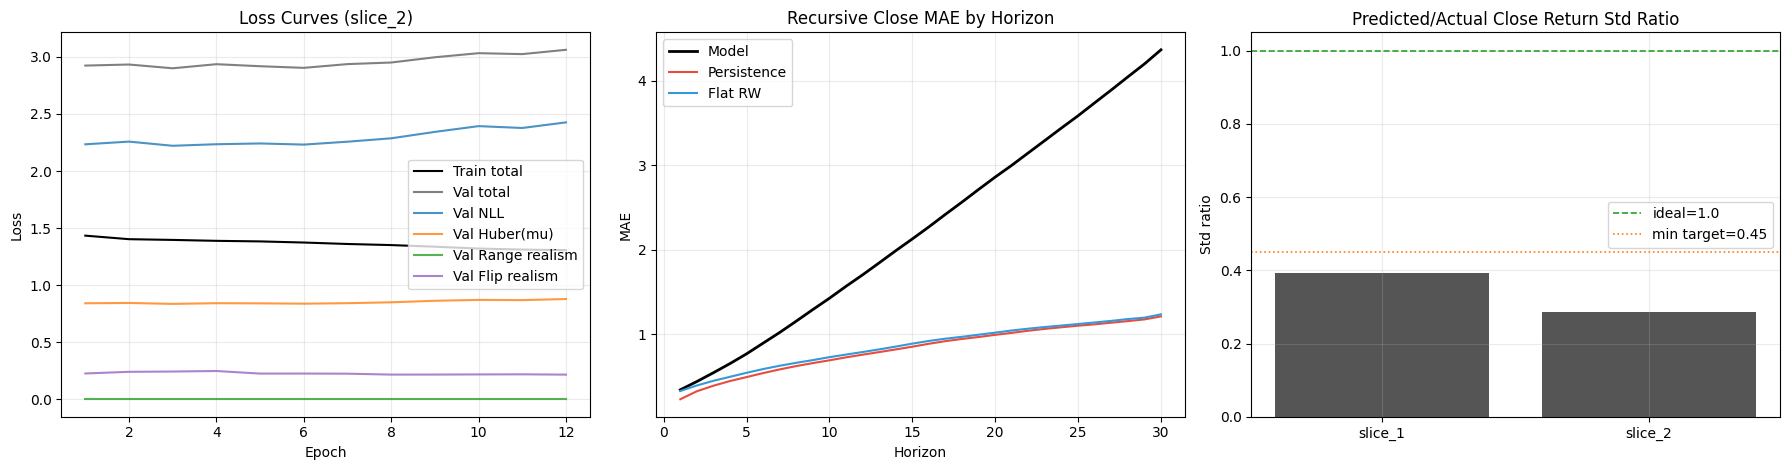

In [10]:
# Acceptance checks + diagnostics
latest = fold_results[-1]

mean_model_mae = float(summary_df['model_close_mae'].mean())
mean_persist_mae = float(summary_df['persist_close_mae'].mean())
mean_dir = float(summary_df['model_directional_acc_eps'].mean())
mean_bias = float(summary_df['model_bias'].mean())
mean_stepH_model = float(summary_df[f'step{HORIZON}_model_mae'].mean())
mean_stepH_persist = float(summary_df[f'step{HORIZON}_persist_mae'].mean())
mean_std_ratio = float(summary_df['pred_actual_std_ratio'].mean())

pred_close_path = latest['pred_future_df_det']['Close'].to_numpy()
is_monotonic = bool(np.all(np.diff(pred_close_path) >= 0) or np.all(np.diff(pred_close_path) <= 0))

acceptance = {
    'criterion_1_model_mae_20pct_better_than_persistence': mean_model_mae <= 0.8 * mean_persist_mae,
    'criterion_2_directional_accuracy_eps_at_least_0_52': mean_dir >= 0.52,
    f'criterion_3_step{HORIZON}_better_than_persistence': mean_stepH_model < mean_stepH_persist,
    'criterion_4_abs_bias_within_25pct_of_mae': abs(mean_bias) <= 0.25 * mean_model_mae,
    'criterion_5_non_monotonic_latest_prediction_path': not is_monotonic,
    'criterion_6_prediction_variance_not_collapsed': mean_std_ratio >= STD_RATIO_TARGET_MIN,
}

print('Selected lookback:', int(summary_df['window'].iloc[0]))
print('Acceptance checks:')
for k, v in acceptance.items():
    print(f'  {k}: {v}')

fig, axes = plt.subplots(1, 3, figsize=(18, 4.8), facecolor='white')

hist = latest['history_df']
axes[0].plot(hist['epoch'], hist['train_total'], label='Train total', color='black')
axes[0].plot(hist['epoch'], hist['val_total'], label='Val total', color='gray')
axes[0].plot(hist['epoch'], hist['val_nll'], label='Val NLL', color='#1f77b4', alpha=0.8)
if 'val_hub' in hist.columns:
    axes[0].plot(hist['epoch'], hist['val_hub'], label='Val Huber(mu)', color='#ff7f0e', alpha=0.8)
if 'val_range' in hist.columns:
    axes[0].plot(hist['epoch'], hist['val_range'], label='Val Range realism', color='#2ca02c', alpha=0.8)
if 'val_flip' in hist.columns:
    axes[0].plot(hist['epoch'], hist['val_flip'], label='Val Flip realism', color='#9467bd', alpha=0.8)
axes[0].set_title(f"Loss Curves ({latest['fold']})")
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(alpha=0.25)
axes[0].legend()

axes[1].plot(horizon_stats['horizon'], horizon_stats['model_close_mae'], label='Model', color='black', linewidth=2.0)
axes[1].plot(horizon_stats['horizon'], horizon_stats['persistence_close_mae'], label='Persistence', color='#E74C3C')
axes[1].plot(horizon_stats['horizon'], horizon_stats['flat_close_mae'], label='Flat RW', color='#3498DB')
axes[1].set_title('Recursive Close MAE by Horizon')
axes[1].set_xlabel('Horizon')
axes[1].set_ylabel('MAE')
axes[1].grid(alpha=0.25)
axes[1].legend()

axes[2].bar(summary_df['fold'], summary_df['pred_actual_std_ratio'], color='#555555')
axes[2].axhline(1.0, color='#2ca02c', linestyle='--', linewidth=1.2, label='ideal=1.0')
axes[2].axhline(STD_RATIO_TARGET_MIN, color='#ff7f0e', linestyle=':', linewidth=1.2, label=f'min target={STD_RATIO_TARGET_MIN}')
axes[2].set_title('Predicted/Actual Close Return Std Ratio')
axes[2].set_ylabel('Std ratio')
axes[2].grid(alpha=0.25)
axes[2].legend()

plt.tight_layout()
plt.show()


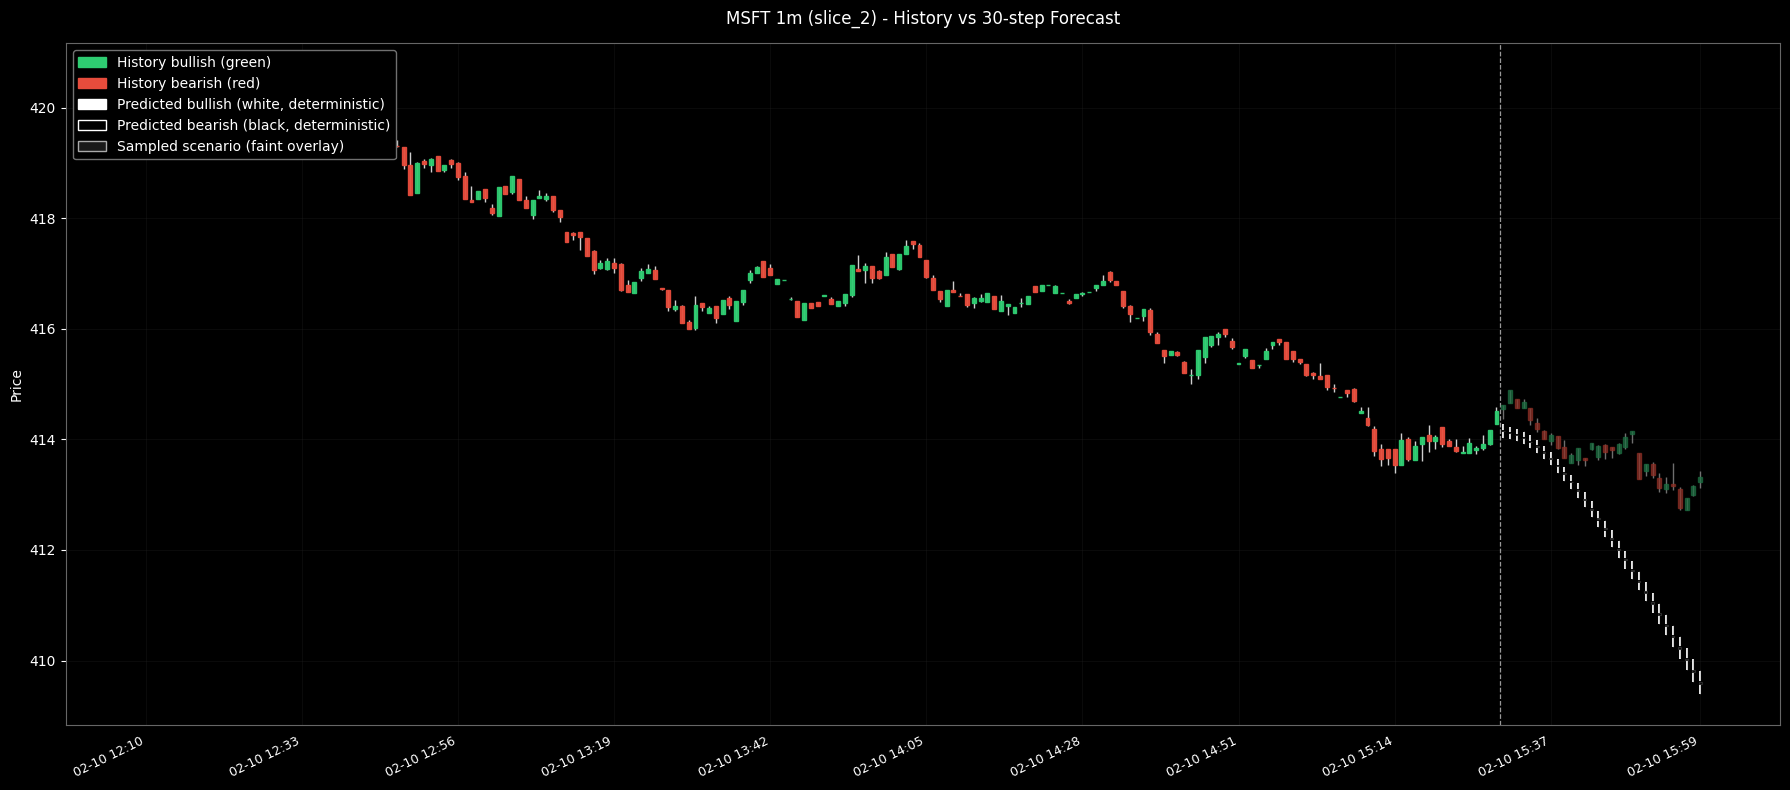

In [11]:
# Final candlestick chart (history green/red, predicted white/black)
def draw_candles(
    ax,
    ohlc: pd.DataFrame,
    start_x: int,
    up_edge: str,
    up_face: str,
    down_edge: str,
    down_face: str,
    wick_color: str,
    width: float = 0.62,
    lw: float = 1.0,
    alpha: float = 1.0,
):
    vals = ohlc[OHLC_COLS].to_numpy()
    for i, (o, h, l, c) in enumerate(vals):
        x = start_x + i
        bull = c >= o

        ax.vlines(x, l, h, color=wick_color, linewidth=lw, alpha=alpha, zorder=2)

        lower = min(o, c)
        height = abs(c - o)
        if height < 1e-8:
            height = 1e-6

        rect = Rectangle(
            (x - width / 2, lower),
            width,
            height,
            facecolor=up_face if bull else down_face,
            edgecolor=up_edge if bull else down_edge,
            linewidth=lw,
            alpha=alpha,
            zorder=3,
        )
        ax.add_patch(rect)


context_df = latest['context_df']
actual_future_df = latest['actual_future_df']
pred_future_df = latest['pred_future_df_det']
pred_future_df_sample = latest['pred_future_df_sample']

fig, ax = plt.subplots(figsize=(18, 8), facecolor='black')
ax.set_facecolor('black')

draw_candles(ax, context_df, 0, '#2ECC71', '#2ECC71', '#E74C3C', '#E74C3C', '#DADADA', width=0.58, lw=1.0, alpha=0.95)
draw_candles(ax, actual_future_df, len(context_df), '#1D6F42', '#1D6F42', '#8E2F25', '#8E2F25', '#9A9A9A', width=0.58, lw=1.0, alpha=0.72)
draw_candles(ax, pred_future_df, len(context_df), '#FFFFFF', '#FFFFFF', '#000000', '#000000', '#F5F5F5', width=0.50, lw=1.35, alpha=1.0)
draw_candles(ax, pred_future_df_sample, len(context_df), '#AAAAAA', '#1A1A1A', '#777777', '#0F0F0F', '#9B9B9B', width=0.42, lw=0.8, alpha=0.35)

ax.axvline(len(context_df) - 0.5, color='white', linestyle='--', linewidth=0.9, alpha=0.6)

idx = context_df.index.append(actual_future_df.index)
n = len(idx)
step = max(1, n // 10)
ticks = list(range(0, n, step))
if ticks[-1] != n - 1:
    ticks.append(n - 1)

labels = [idx[i].strftime('%m-%d %H:%M') for i in ticks]
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=26, ha='right', color='white', fontsize=9)

ax.tick_params(axis='y', colors='white')
for sp in ax.spines.values():
    sp.set_color('#666666')

ax.grid(color='#252525', linewidth=0.6, alpha=0.35)
ax.set_title(f'MSFT 1m ({latest["fold"]}) - History vs {HORIZON}-step Forecast', color='white', pad=14)
ax.set_ylabel('Price', color='white')

legend_elements = [
    Patch(facecolor='#2ECC71', edgecolor='#2ECC71', label='History bullish (green)'),
    Patch(facecolor='#E74C3C', edgecolor='#E74C3C', label='History bearish (red)'),
    Patch(facecolor='#FFFFFF', edgecolor='#FFFFFF', label='Predicted bullish (white, deterministic)'),
    Patch(facecolor='#000000', edgecolor='#FFFFFF', label='Predicted bearish (black, deterministic)'),
    Patch(facecolor='#1A1A1A', edgecolor='#AAAAAA', label='Sampled scenario (faint overlay)'),
]
leg = ax.legend(handles=legend_elements, facecolor='black', edgecolor='#707070', framealpha=1.0, loc='upper left')
for t in leg.get_texts():
    t.set_color('white')

plt.tight_layout()
plt.show()


## Notes

- If `pred_actual_std_ratio` remains low, the model is still volatility-collapsed.
- The chart now displays the sampled recursive path (`temperature` controlled), not only deterministic mean path.
- For stricter realism, next step is quote-level order-book imbalance features from NBBO/trades data.
